In [2]:
# Загружем необходимые библиотеки

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Загрузка и предобработка данных

In [121]:
df = pd.read_csv('cookie_cats_ab.csv')

In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [7]:
# Проверим типы данных
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [11]:
# Посмотрим на размерность датасета
df.shape

(90189, 5)

| Название колонки | Тип данных | Описание |
|-------------------|-------------|----------|
| **userid**        | int    | Уникальный идентификатор игрока (пользователя). |
| **version**       | object | Группа, в которую был помещён игрок: **gate_30** (контрольная группа, шлюз на 30-м уровне) или **gate_40** (тестовая группа, шлюз на 40-м уровне). |
| **sum_gamerounds**| int    | Количество игровых раундов, сыгранных пользователем в течение первой недели после установки игры. |
| **retention_1**   | boolean | Возврат игрока через 1 день после установки: `True`/`1` — вернулся и сыграл, `False`/`0` — не вернулся. |
| **retention_7**   | boolean | Возврат игрока через 7 дней после установки: `True`/`1` — вернулся и сыграл, `False`/`0` — не вернулся. |

In [8]:
# Проверим датасет на пропущенные значения
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [87]:
# Проверим, все ли пользователи уникальны
if df.userid.nunique() == df.shape[0]:
    print('Все пользователи уникальные')
else:
    print('В датасете присутствуют неуникальные пользователи')

Все пользователи уникальные


## 2. EDA

In [70]:
df.query('sum_gamerounds == 0').userid.count()

np.int64(3994)

3994 пользователя установили игру, но ни разу не сыграли ни одного раунда.

#### Возможные причины такого поведения:

*   **Нехватка свободного времени:** У пользователей может просто не быть времени на игру после установки.
*   **Конкуренция с другими играми:** Возможно, пользователи предпочитают другие игры или уже играют в них.
*   **Низкая вовлечённость или несоответствие ожиданиям:** Приложение могло не понравиться с первого взгляда (интерфейс, геймплей, реклама).
*   **Технические проблемы:** Игра может не запускаться на некоторых устройствах или возникают ошибки при старте.
*   **Пассивная установка:** Игра могла быть установлена случайно или «для галочки», без реального намерения играть.
*   **Отсутствие мотивации:** Нет немедленного стимула или понятного руководства, чтобы сделать первый ход.

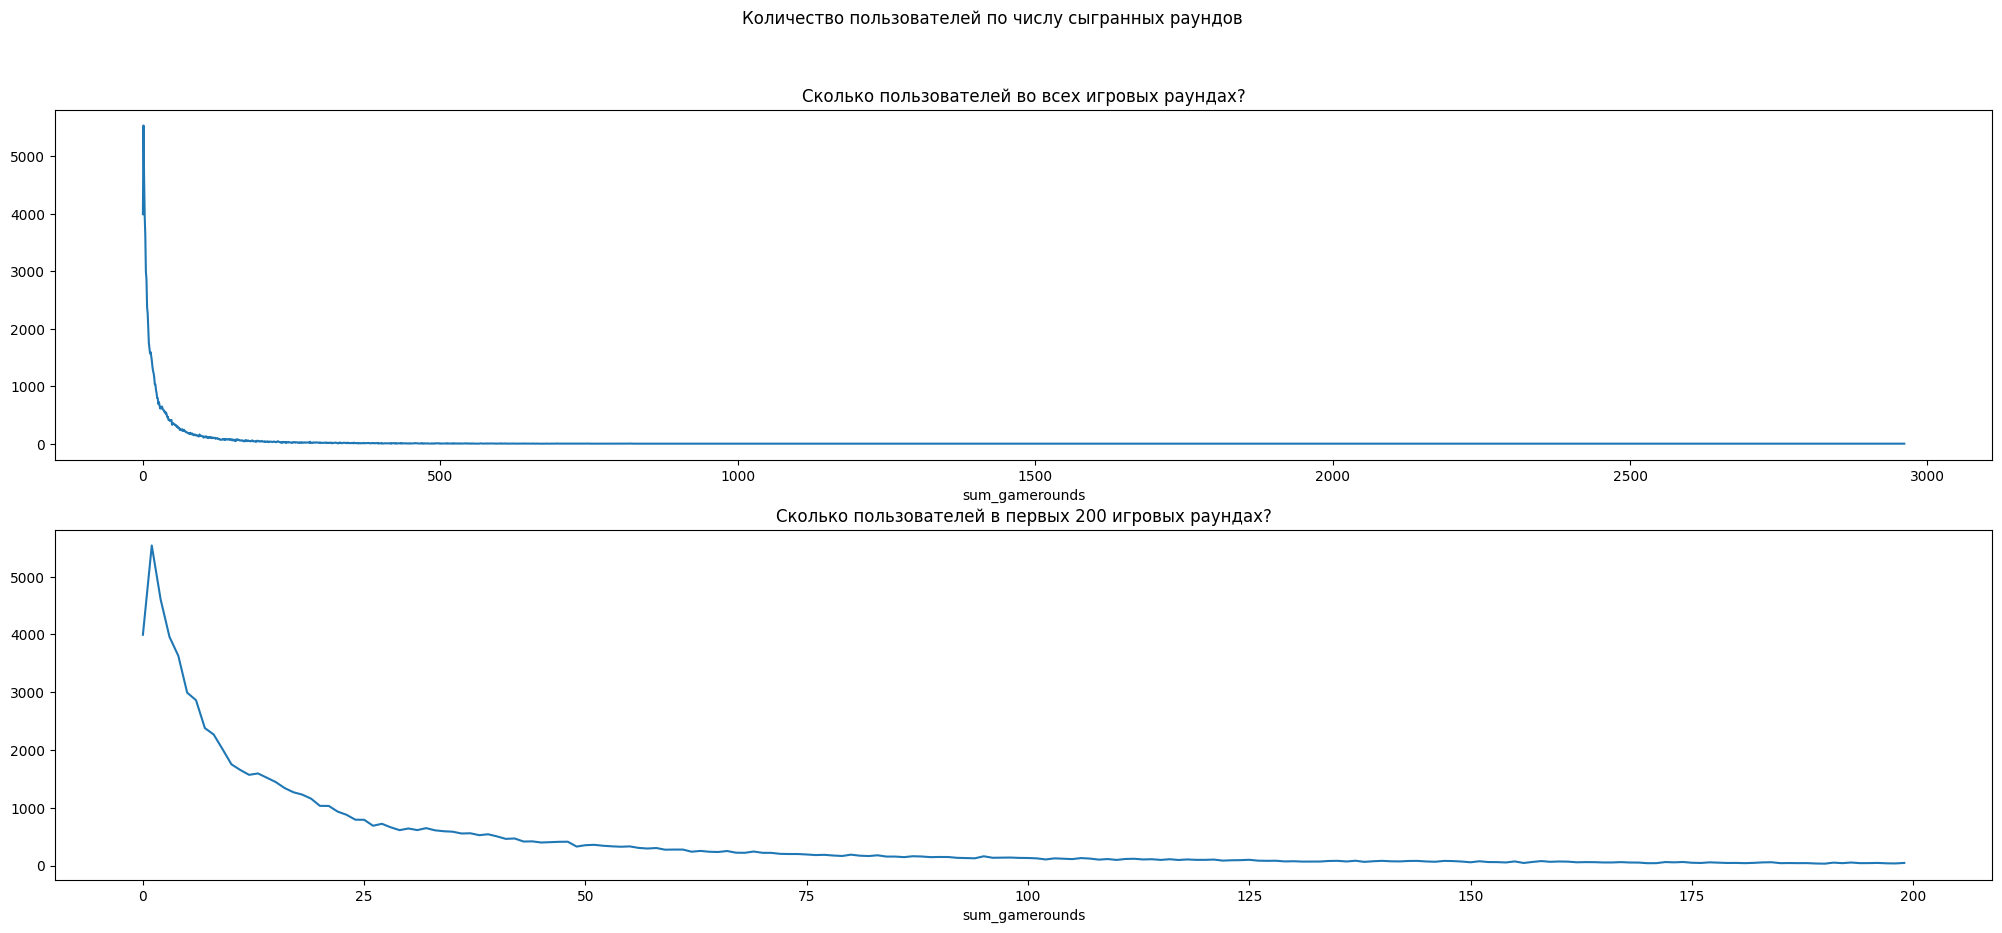

In [80]:
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

df.groupby('sum_gamerounds').userid.count().plot(ax = axes[0])
df.groupby('sum_gamerounds').userid.count()[:200].plot(ax = axes[1])

plt.suptitle("Количество пользователей по числу сыгранных раундов")
axes[0].set_title("Сколько пользователей во всех игровых раундах?")
axes[1].set_title("Сколько пользователей в первых 200 игровых раундах?")
plt.show()

In [83]:
df.groupby('sum_gamerounds').userid.count().rename('users_count').head(20)

sum_gamerounds
0     3994
1     5538
2     4606
3     3958
4     3629
5     2992
6     2861
7     2379
8     2267
9     2013
10    1752
11    1654
12    1570
13    1594
14    1519
15    1446
16    1342
17    1269
18    1228
19    1158
Name: users_count, dtype: int64

**Количество пользователей сокращается по мере прохождения уровней**

### Текущая ситуация
- Большинство пользователей играет только на ранних этапах и не прогрессирует дальше
- Наблюдается значительный отток после начальных уровней

**Рекомендации для Tactile Entertainment**

1. **Исследование причин оттока**
- Провести анализ, чтобы понять, почему пользователи перестают играть
- Собрать дополнительные данные о поведении пользователей и особенностях игры

2. **Оценка сложности игры**
- Измерить уровень сложности на разных этапах игры
- Выявить потенциальные "точки трения", где пользователи чаще всего бросают игру

3. **Стимулирование удержания**
- Внедрить систему подарков и наград для поддержания интереса
- Продумать механику поощрений для игроков, проходящих критические уровни

---

Посмотрим, сколько пользователей достигли уровня 30 и 40

In [86]:
df.groupby('sum_gamerounds').userid.count().iloc[[30, 40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

## 3. Статистические меры и Распределения

In [ ]:
# Посмотрим на базовые меры всего датасета
df.describe()[['sum_gamerounds']].T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


In [20]:
# Посмотрим на базовые меры в разрезе групп A/B
df.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)

,count,mean,std,min,max
version,,,,,
gate_30,44700,52.46,256.72,0,49854
gate_40,45489,51.30,103.29,0,2640


**Видно, что размах выборки выборки для группы A большой, вероятно это выбросы. Построим распределения, чтобы убедиться в этом**

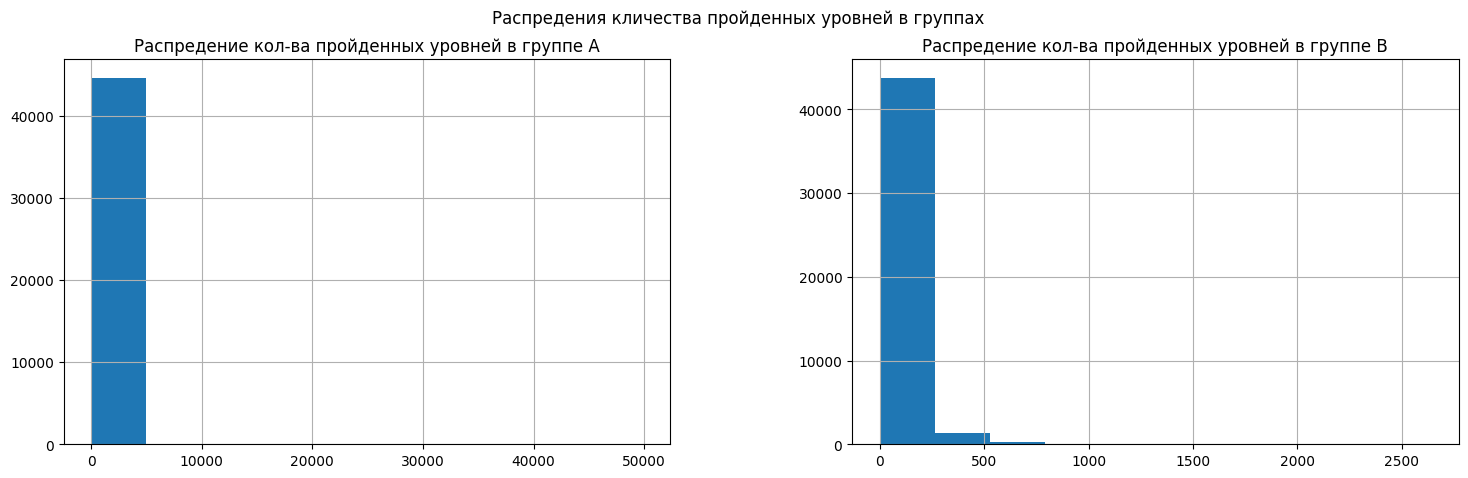

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
df.query('version == "gate_30"').hist('sum_gamerounds', ax = axes[0])
df.query('version == "gate_40"').hist('sum_gamerounds', ax = axes[1])

plt.suptitle("Распредения кличества пройденных уровней в группах")
axes[0].set_title("Распредение кол-ва пройденных уровней в группе A")
axes[1].set_title("Распредение кол-ва пройденных уровней в группе B")
plt.show()

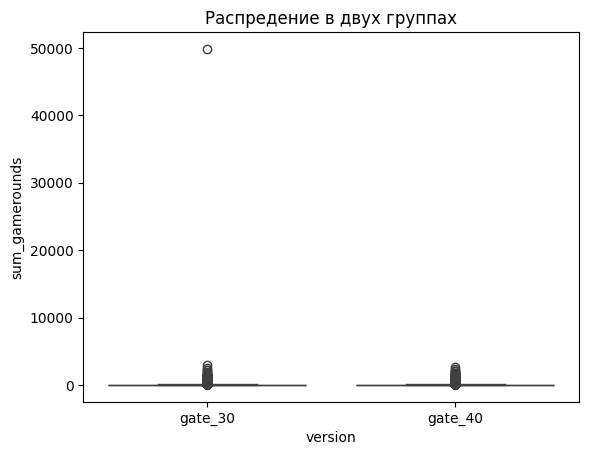

In [43]:
sns.boxplot(x = df.version, y = df.sum_gamerounds)

plt.title('Распредение в двух группах')
plt.show()

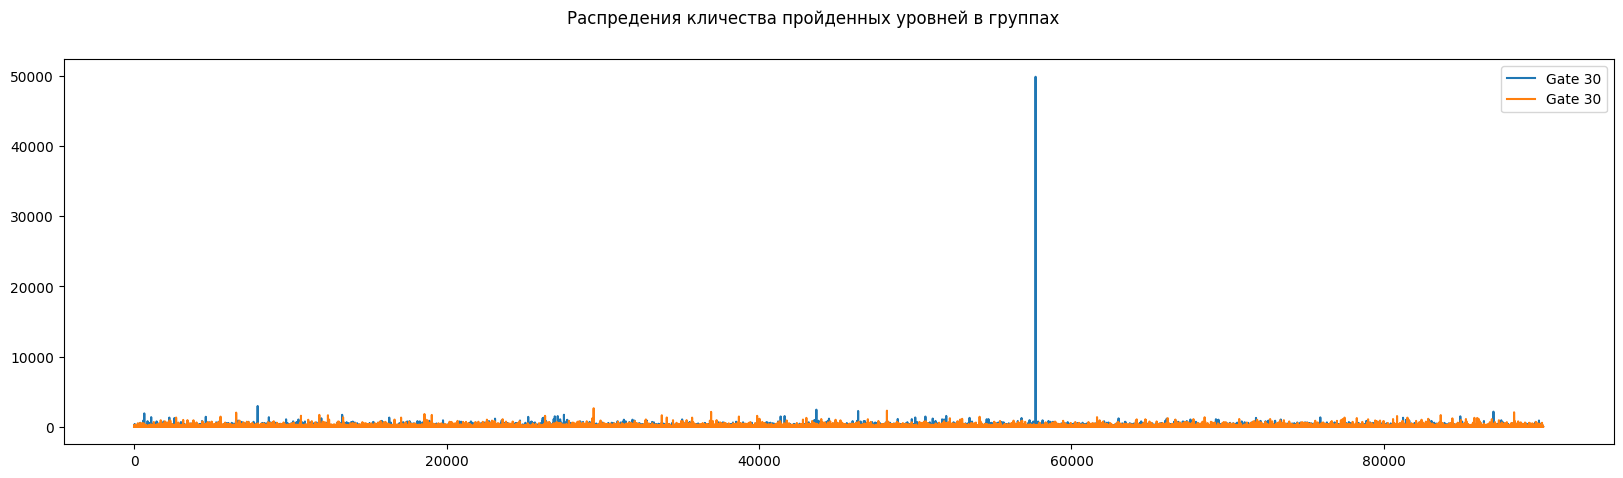

In [42]:
df.query('version == "gate_30"').sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))
df.query('version == "gate_40"').sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))

plt.suptitle("Распредения кличества пройденных уровней в группах")
plt.show()

**Из распределений видно, что есть один выброс в группе A (gate_30). Необходимо избавиться от данного выброса, так как это может существенно исказить результат статистического теста**

In [49]:
# Избавляемся от выброса
df = df[df.sum_gamerounds < 20000]

In [52]:
df.sum_gamerounds.describe().round(2)

count    90188.00
mean        51.32
std        102.68
min          0.00
25%          5.00
50%         16.00
75%         51.00
max       2961.00
Name: sum_gamerounds, dtype: float64

*Проверим, как изменились распределения после удаления выброса*

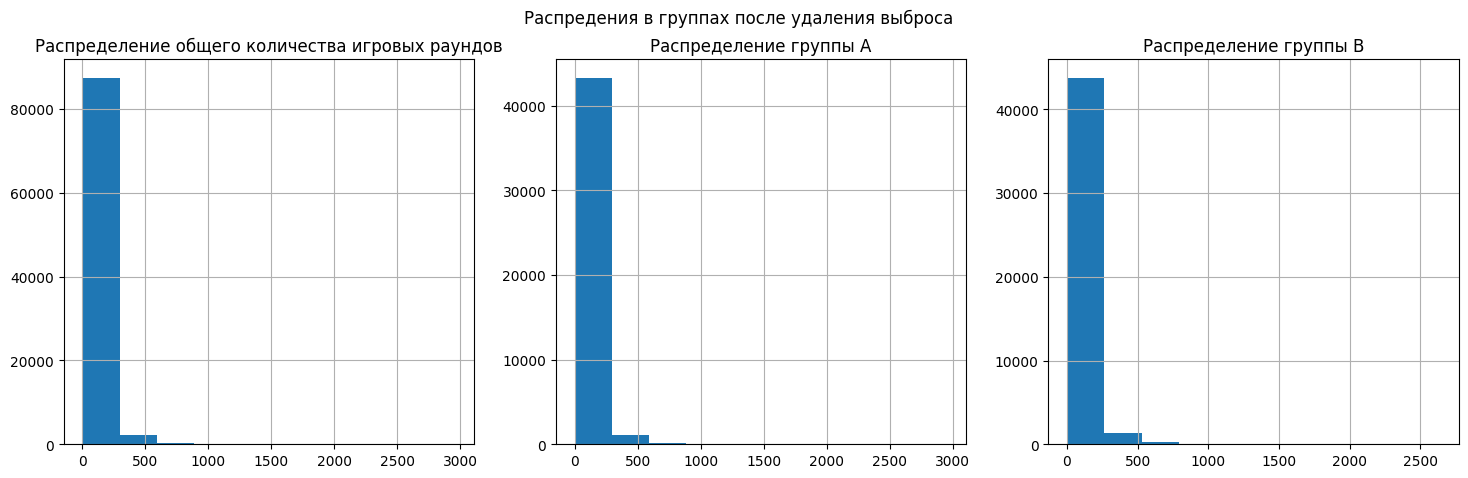

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df.sum_gamerounds.hist(ax=axes[0])
df.query('version == "gate_30"').sum_gamerounds.hist(ax=axes[1])
df.query('version == "gate_40"').sum_gamerounds.hist(ax=axes[2])

plt.suptitle("Распредения в группах после удаления выброса")
axes[0].set_title("Распределение общего количества игровых раундов")
axes[1].set_title("Распределение группы A")
axes[2].set_title("Распределение группы B")
plt.show()


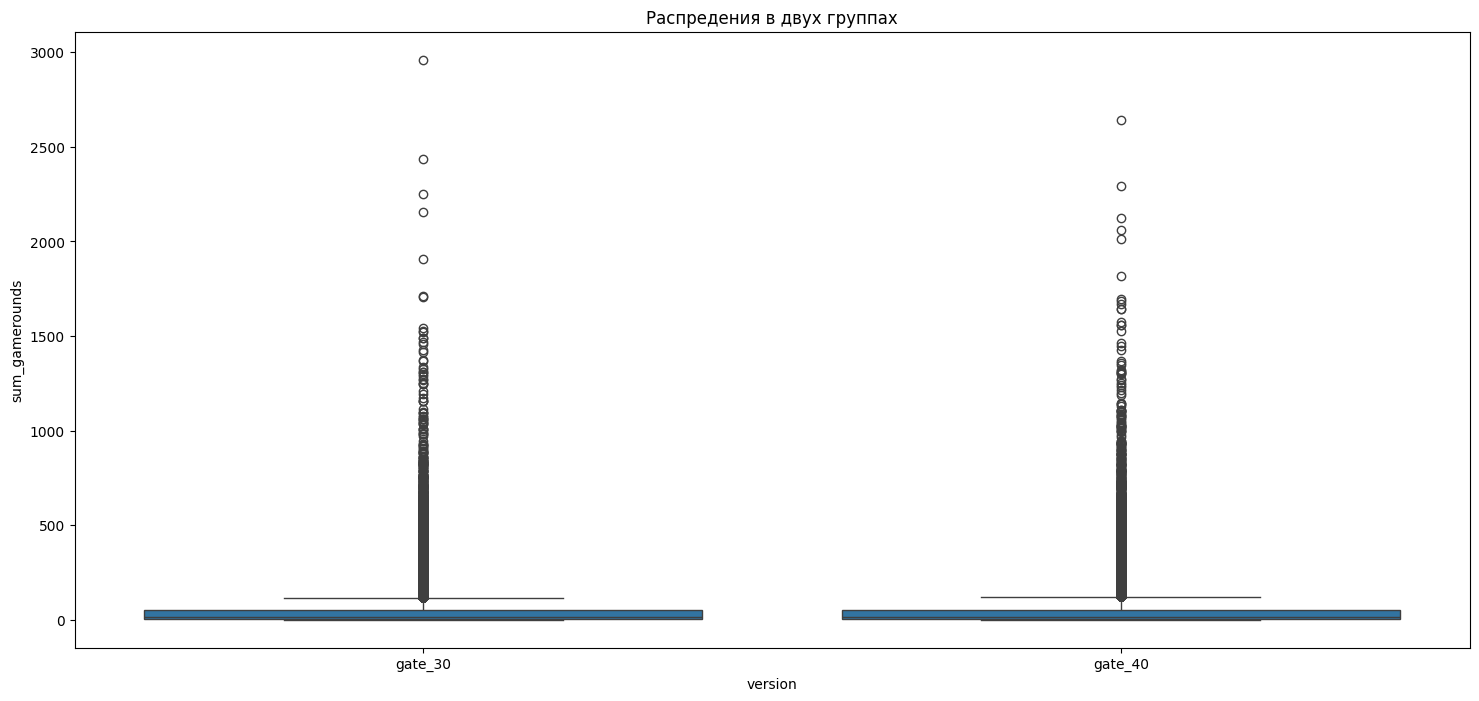

In [65]:
plt.subplots(figsize=(18, 8))
sns.boxplot(x = df.version, y = df.sum_gamerounds)

plt.title("Распредения в двух группах")
plt.show()

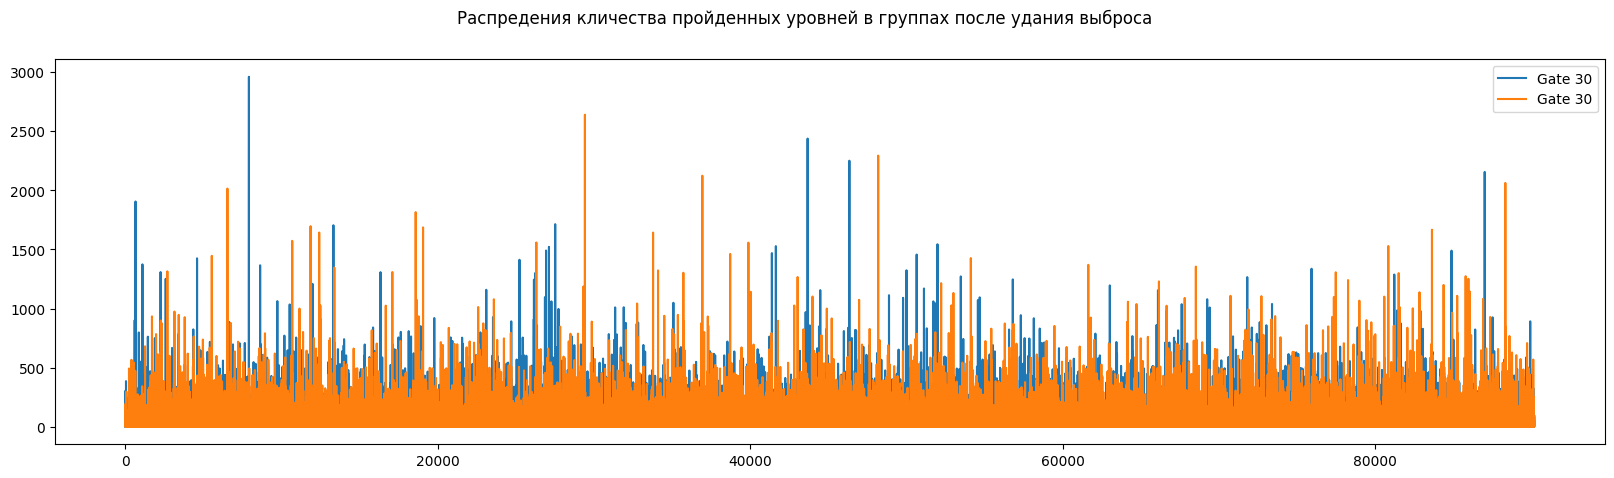

In [66]:
df.query('version == "gate_30"').sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))
df.query('version == "gate_40"').sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))

plt.suptitle("Распредения кличества пройденных уровней в группах после удания выброса")
plt.show()

*Заметно, что распредение в группах почти одинаковое. Посмотрим на статистические меры в разрезе обеих групп*

In [89]:
df.groupby('version').sum_gamerounds.agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

,count,mean,median,std,min,max
version,,,,,,
gate_30,44699,51.34,17.0,102.06,0,2961
gate_40,45489,51.30,16.0,103.29,0,2640


*Также посмотрим на retantion*

In [111]:
retantion = df.retention_1.value_counts().rename('ret1_count').to_frame() \
    .merge(df.retention_7.value_counts().rename('ret7_count').to_frame(), left_index=True, right_index=True) \
    .merge(df.retention_1.value_counts().rename('ret1_ratio').to_frame()/len(df)*100, left_index=True, right_index=True) \
    .merge(df.retention_7.value_counts().rename('ret7_ratio').to_frame()/len(df)*100, left_index=True, right_index=True) \
    .round(2)

In [112]:
retantion

,ret1_count,ret7_count,ret1_ratio,ret7_ratio
retention_1,,,,
False,50035,73408,55.48,81.39
True,40153,16780,44.52,18.61


*Видно, что игроки не заинтересованы продолжать играть. Много игроков уходят в отток.*
 - 55 % игроков перестали играть через 1 день после установки
 - 81 % игроков перестали играть через 7 дней после установки

*Также посмотрим на retantion в разрезе групп*

In [114]:
df.groupby(['version', 'retention_1']).sum_gamerounds.agg(['count', 'mean', 'median', 'std', 'min', 'max'])

count       mean  median         std  min   max
version retention_1                                                 
gate_30 False        24665  16.359092     6.0   36.528426    0  1072
        True         20034  94.411700    48.0  135.037697    0  2961
gate_40 False        25370  16.340402     6.0   35.925756    0  1241
        True         20119  95.381182    49.0  137.887256    0  2640

In [115]:
df.groupby(['version', 'retention_7']).sum_gamerounds.agg(['count', 'mean', 'median', 'std', 'min', 'max'])

count        mean  median         std  min   max
version retention_7                                                  
gate_30 False        36198   25.796508    11.0   43.316158    0   981
        True          8501  160.117516   105.0  179.358560    0  2961
gate_40 False        37210   25.856356    11.0   44.406112    0  2640
        True          8279  165.649837   111.0  183.792499    0  2294

### Предварительные наблюдения
При рассмотрении сводной статистики по переменным удержания (`retention_1` и `retention_7`) в разрезе версий (`gate_30` и `gate_40`) и их сравнении с количеством игровых раундов (`sum_gamerounds`) наблюдаются схожие показатели между группами.

### Необходимость дальнейшего анализа
Однако для уверенных выводов необходимо проверить, существует ли **статистически значимая разница** между контрольной и тестовой группами

## 4. Анализ A/B эксперимента

Для удобства названия в колонке `version` на `A` и `B`

In [116]:
df['version'] = np.where(df.version == 'gate_30', 'A', 'B')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


**Напишу функцию для проверки статистической значимости двух групп**

P.S.: Для сравнения средних значений между группами применяется параметрический t-тест (ttest_ind), так как:

1. **Независимость наблюдений**: Пользователи распределены между контрольной и тестовой группами случайным образом
2. **Нормальность распределения**: При большом объёме выборки (~90 тыс. наблюдений) можно опираться на центральную предельную теорему
3. **Гомогенность дисперсий**: Определяется с помощью теста Левена (Levene's test), после чего в t-тесте устанавливается параметр `equal_var` (True/False)
4. **Баланс групп**: Количество участников в группах примерно равное

In [117]:
def ab_analyze(df, group, target):

    # Установим необходимые модули
    import scipy.stats as stats

    # Разделим выборки по группам
    group_A = df[df[group] == 'A'][target]
    group_B = df[df[group] == 'B'][target]

    # Проверка гомогенности дисперсий между группами
    leven_test = stats.levene(group_A, group_B)[1] < 0.05
    # H0: Дисперсии гомогенны - False
    # H1: Дисперсии гетерогенны - True

    if leven_test is False:
        # Гомогенность
        ttest = stats.ttest_ind(group_A, group_B, equal_var=True)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
    else:
        # Гетерогенность
        ttest = stats.ttest_ind(group_A, group_B, equal_var=False)[1]
    
    # Результат
    result = pd.DataFrame({
        "AB Hypothesis": [ttest < 0.05],
        "p-value": [ttest]
    })

    result["Test Type"] = 'Parametric'

    result["AB Hypothesis"] = np.where(result["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")

    result["Comment"] = np.where(result["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    result["Homogeneity"] = np.where(leven_test == False, "Yes", "No")

    # Описание гипотезы для удобства
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return result

In [118]:
ab_analyze(df=df, group='version', target='sum_gamerounds')

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,AB Hypothesis,p-value,Test Type,Comment,Homogeneity
0,Fail to Reject H0,0.949469,Parametric,A/B groups are similar!,Yes


## 5. Заключение

#### Напоминание о бизнес-задаче

**Контекст**
В игре Cookie Cats игроки встречают "шлюзы" (gates), которые вынуждают их:
1. **Ждать определённое время** перед продолжением игры
2. **Совершить внутриигровую покупку** для мгновенного прохождения

#### Цель A/B-теста
В данном проекте мы анализируем результат переноса **первого шлюза**:
- **Контрольная группа (A):** шлюз на 30-м уровне
- **Тестовая группа (B):** шлюз на 40-м уровне

#### Основные метрики анализа
1. **Удержание игроков (retention)**
2. **Количество игровых раундов**

#### Ход анализа

**1. Подготовительный этап**
До проведения анализа A/B-теста были представлены:
- Обзор игры и игровой механики
- Анализ поведения игроков
- Выявленные проблемы и предложения по их решению

**2. Исследование данных**
- **Пропущенных значений** не обнаружено
- **Выбросы:** выявлена одна проблема с аномальными значениями
- **Описательная статистика и визуализации** помогли понять структуру данных

#### 3. Проведение анализа A/B-теста
**Выбранный метод:**
- **T-Test** для сравнения двух средних в двух группах

### 4. Результаты тестирования
- **T-Test** не отверг нулевую гипотезу (H₀)
- **Статистический вывод:** средние в группах A и B не различаются значимо

## Ключевой вывод

**Перенос первого шлюза с 30-го на 40-й уровень не создаёт статистически значимые различия в количестве игровых раундов между контрольной и тестовой группами.**

### Практическая значимость:
Изменение позиции шлюза не влияет на:
1. **Игровое поведение** (количество сыгранных раундов)
2. **Показатели удержания** (требует дополнительной проверки)
3. **Монетизационный потенциал** игры

**Какая версия имеет более лучшие показатели по retantion?**

In [120]:
df.groupby('version').retention_1.mean(), df.groupby('version').retention_7.mean()

(version
 A    0.448198
 B    0.442283
 Name: retention_1, dtype: float64,
 version
 A    0.190183
 B    0.182000
 Name: retention_7, dtype: float64)